#Siamese Network using Triplet Loss on MNIST

Insipired by Pyimagesearch and code snippets from <br> https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/ <br> and from https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463

Importing dependencies

In [ ]:
import os
import cv2
import json
import time
import random
import csv
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from sklearn.decomposition import PCA
from random import shuffle
from tqdm import tqdm

Importing data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling our values
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


Creating our triplets

In [ ]:
def create_batch(batch_size=256):
    """" Creating batches of our Triplets with a default Batch Size of 256 """
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]


def plot_triplets(examples):
    """" Visualizing our triplets """
    plt.figure(figsize=(10, 10))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if i == 0:
          plt.title("ANCHOR", fontsize=24, ha='center')
        elif i == 1:
          plt.title("POSITIVE", color='g', fontsize=24, ha='center') 
        elif i == 2:
          plt.title("NEGATIVE", color='r', fontsize=24, ha='center')
    plt.show()    

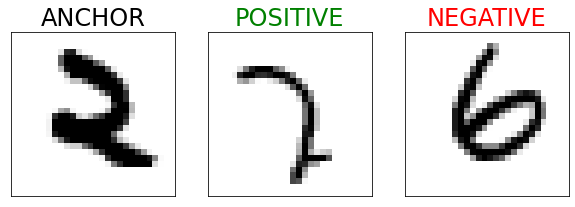

In [ ]:
triplet_example = create_batch(1)
plot_triplets(triplet_example)

Visualizing data through PCA

In [ ]:
## Importing and Apply PCA

pca = PCA(n_components=3) # project from 784 to 3 dimensions
principalComponents = pca.fit_transform(x_test)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principal_df.shape

(10000, 3)

In [ ]:
labels = list(np.unique(y_test))

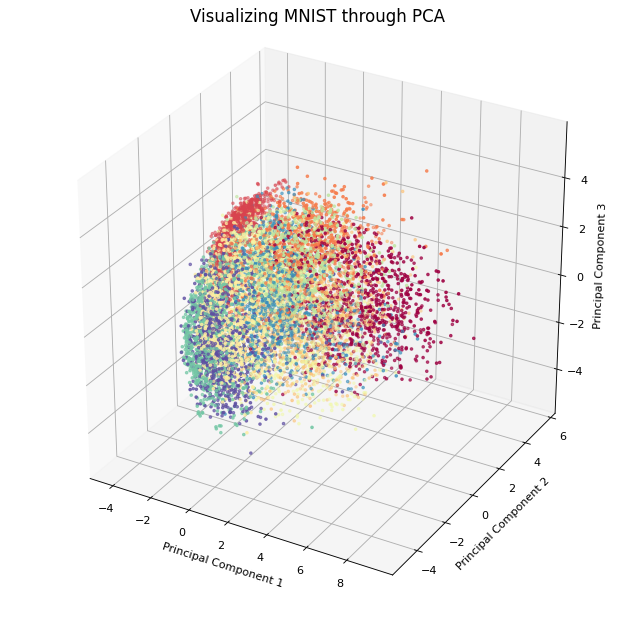

In [ ]:
# Plot the first two principal components of each point to learn about the data:

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], s= 5, c=y_test, cmap='Spectral')
ax.set_title('Visualizing MNIST through PCA', fontsize=15, y=1.05);
ax.set_xlabel('Principal Component 1');
ax.set_ylabel('Principal Component 2');
ax.set_zlabel('Principal Component 3');

Adding step in keras to show PCA after our embeddings

In [ ]:
class PCAPlotter(tf.keras.callbacks.Callback):
    """ Used to show what PCA looks like on our embeddings"""
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(20, 10))
        self.ax1 = plt.subplot(1, 2, 1, projection='3d')
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []

    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=3).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.set_title('Visualizing MNIST embeddings through PCA', fontsize=15, y=1.05)
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], pca_out[:, 2], s=5, c=self.y_test, cmap='Spectral')
        self.ax1.set_xlabel('Principal Component 1')
        self.ax1.set_ylabel('Principal Component 2')
        self.ax1.set_zlabel('Principal Component 3')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_title('Triplet Loss vs Epochs', fontsize=15, y=1.05)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

# Defining Our Loss Function - Triplet Loss

![Assignment 1.jpg](https://drive.google.com/uc?export=view&id=1UddSvWiZOx30m5A0RW-DbqY_TbCkzpo_)

In [ ]:
# Let alpha = 0.2

alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

"You’ll often see SNNs using this loss function called Triplet Networks as if they are their own thing (and indeed this is how they are defined by Hoffer et al. in the paper that first conceived them [4]) but really they’re just an SNN with three branches" <br>- https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463

# Defining our data generation function

In [ ]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Goal of our Siamese  Network

![Siamese.jpg](https://drive.google.com/uc?export=view&id=13U3gB4qjPBlWb8iW5Rc7H3IPfxi6N8wG)

During training, each of our triplet components is fed to its own CNN branch to be embedded; which are then passed onto our triplet loss function. The goal would be push the anchor and positive embeddings closer together, while pushing the negative further away. <br> <br> <i> Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

# Creating our Siamese Network Model Structure

In [ ]:
emb_size = 64

# This is a Super Simplistic Keras model
embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
Total params: 58,560
Trainable params: 58,560
Non-trainable params: 0
_________________________________________________________________


3 inputs based on our triplets and 3 embeddings that will be learned

In [ ]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

siamese_model = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           58560       input_1[0][0]                    
                                                                 input_2[0][0]                

Running our model

Epoch 1/10
29/29 [==============================] - 22s 762ms/step - loss: 0.1624
Epoch 2/10
29/29 [==============================] - 22s 758ms/step - loss: 0.0753
Epoch 3/10
29/29 [==============================] - 21s 731ms/step - loss: 0.0581
Epoch 4/10
29/29 [==============================] - 22s 755ms/step - loss: 0.0490
Epoch 5/10
29/29 [==============================] - 22s 758ms/step - loss: 0.0433
Epoch 6/10
29/29 [==============================] - 21s 731ms/step - loss: 0.0401
Epoch 7/10
29/29 [==============================] - 22s 752ms/step - loss: 0.0366
Epoch 8/10
29/29 [==============================] - 22s 764ms/step - loss: 0.0344
Epoch 9/10
29/29 [==============================] - 21s 731ms/step - loss: 0.0311
Epoch 10/10
29/29 [==============================] - 22s 765ms/step - loss: 0.0290


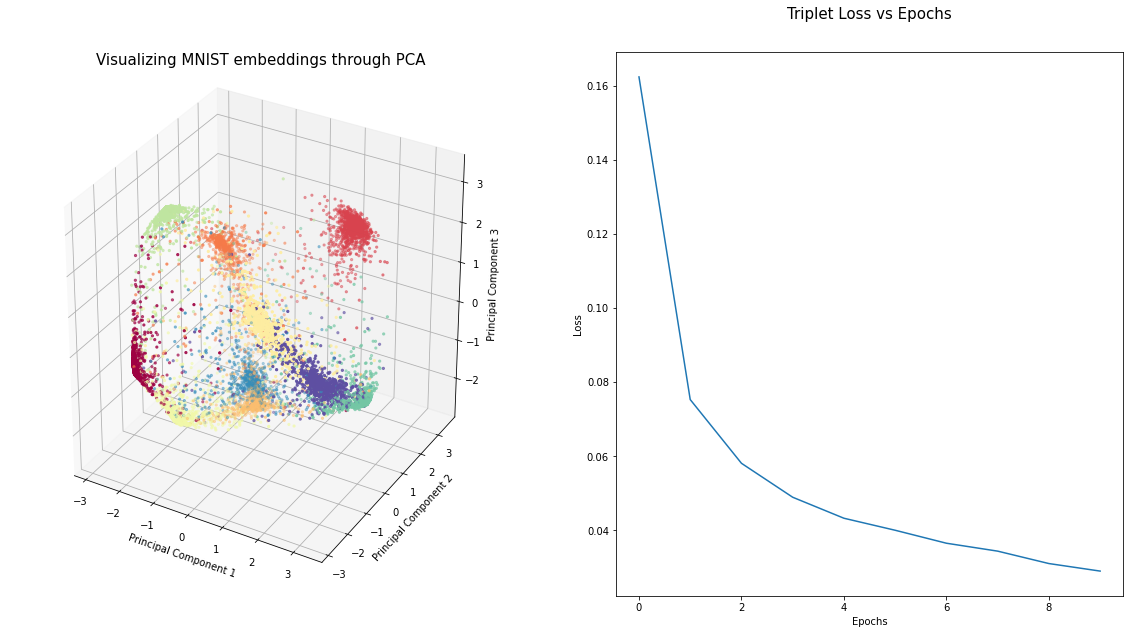

In [ ]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

siamese_model.compile(loss=triplet_loss, optimizer='adam')

siamese_network = siamese_model.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test, y_test
        )]
)

We can see the embeddings have grouped our similar images together and pushed the further ones apart!